## Overview

### External Interface Requirements
1. Input requirement: capacity to read a dataset stored on disk.
2. Output requirement: report on optimal number of clusters, centroid coordinates and quality metric.
3. Output requirement: identifiers of classes corresponding to new instances classified by the model.

### Functional Requirements
1. The software must learn a clusterization a the dataset.
2. The software must use the learned clusterization to classify new problem instances.
3. The software must evaluate the quality of a clusterization.
4. The software must be flexible to work with different preconfigured amount of clusters.
5. The software must compare results using different numbers of clusters and determine which number of clusters is best.


### Necessary Deliverables
1. Python application that performs ETL, training, and testing.
2. Report containing quality metrics, and explanation of the dataset, and the experimental procedure (range of the different number of clusters that were tested, how the range was traversed, etc.).

### Further notes
	- Find data & understand it (sometimes need to aggregate rows of data as each line is not unique) 
    - Perform data cleaning&feature engineering 
	- First find all different clusters (types) of clients/products 
	- 2nd find their characteristics 

In [345]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [346]:
taxi = pd.read_csv('../data/train.csv')

### Exploring the data & variables

In [347]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [348]:
taxi.shape

(1458644, 11)

In [349]:
taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [350]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [351]:
missing = taxi.isnull().sum()
missing

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

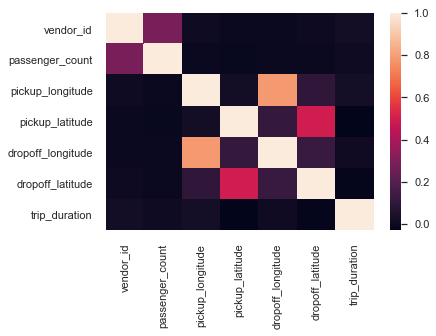

In [352]:
sns.heatmap(taxi.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a39474630>,
      dtype=object)

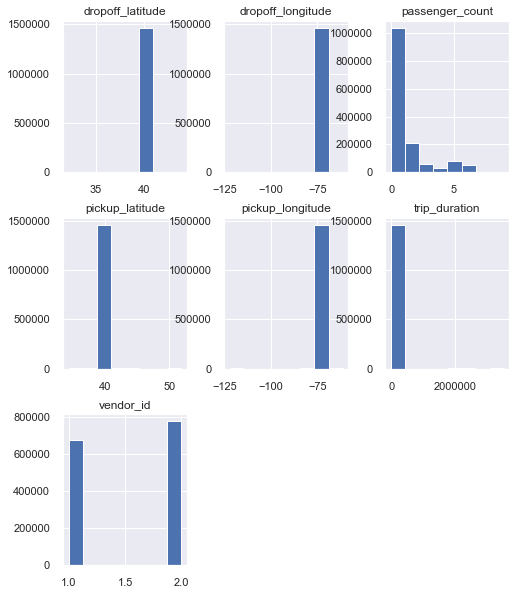

In [353]:
taxi.hist(figsize=(8,10), bins=8, color='b')

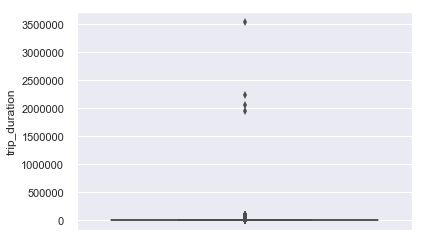

In [354]:
sns.boxplot(y='trip_duration', data=taxi, color='b')

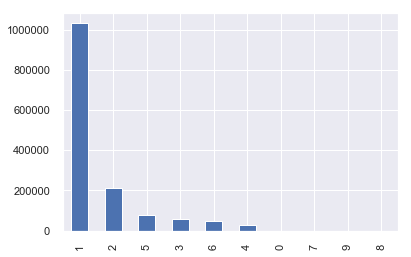

In [355]:
taxi.passenger_count.value_counts().plot.bar(color='b')

In [356]:
taxi.trip_duration.max(), taxi.trip_duration.min()

(3526282, 1)

In [357]:
print('max hours: ' , 3526282/60/60)

max hours:  979.5227777777778


Check for any trips longer than 3 h

In [358]:
taxi[taxi.trip_duration > 10800]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197
4336,id3632390,2,2016-06-08 08:54:33,2016-06-09 07:58:09,5,-73.980560,40.742466,-73.984718,40.748611,N,83016
5104,id3354426,2,2016-05-05 15:18:41,2016-05-06 15:11:07,1,-73.989037,40.773514,-73.980682,40.781521,N,85946
5778,id0773526,2,2016-04-02 14:58:45,2016-04-03 14:19:55,6,-73.987991,40.761341,-74.002922,40.756279,N,84070
6132,id3617210,2,2016-03-15 17:51:32,2016-03-16 17:18:04,1,-73.965607,40.765781,-73.972649,40.753418,N,84392
6513,id0067152,2,2016-02-27 21:04:05,2016-02-28 21:03:22,5,-73.993744,40.727444,-74.001335,40.729244,N,86357


There are > 2000 rows with trip duration longer than 10h; will drop as outliers (initially they were kept in the df and when running the model, clustering created 2 clusters with long trip durations and there were only 2-3 values in each cluster, so clearly these values are not helping the model)

In [359]:
taxi.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [360]:
taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Might drop the 2 columns above as they are not significant for the clustering, along with the id column

### Visualize the Data to Gain Insights

#### Exploring longitude & latitude

In [361]:
taxi_sample = taxi.sample(10000)

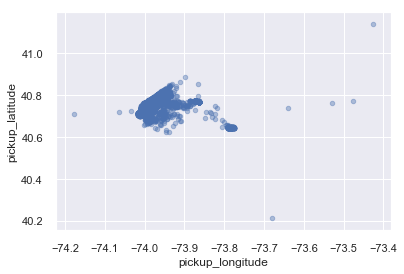

In [362]:
taxi_sample.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, color='b')

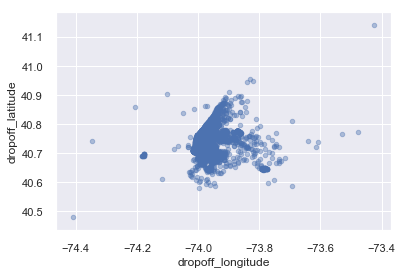

In [363]:
taxi_sample.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4, color='b')

Remove far away destinations to get more clarity on the data for trips that originated & terminated within New York

In [364]:
taxi.pickup_latitude.min(), taxi.pickup_latitude.max()

(34.359695434570305, 51.88108444213867)

In [365]:
taxi.pickup_longitude.min(), taxi.pickup_longitude.max()

(-121.93334197998048, -61.33552932739258)

The area of NYC we will focus is: latitude between 40.6921 and 40.8730, and longitude between -74.0753 and -73.8116

In [366]:
taxi_coordinates = taxi_sample[(taxi_sample.pickup_latitude > 40.6921) & 
                                      (taxi_sample.pickup_latitude < 40.8730) &
                                      (taxi_sample.pickup_longitude > -74.0753) & 
                                      (taxi_sample.pickup_longitude < -73.8116) &
                                      (taxi_sample.dropoff_latitude > 40.6921) & 
                                      (taxi_sample.dropoff_latitude < 40.8730) &
                                      (taxi_sample.dropoff_longitude > -74.0753) & 
                                      (taxi_sample.dropoff_longitude < -73.8116)]

Also drop the rows with trip duration > 3h as outliers

In [367]:
taxi_coordinates = taxi_coordinates[taxi_coordinates.trip_duration < 10800]

In [383]:
map_= plt.imread('../NYC.png')

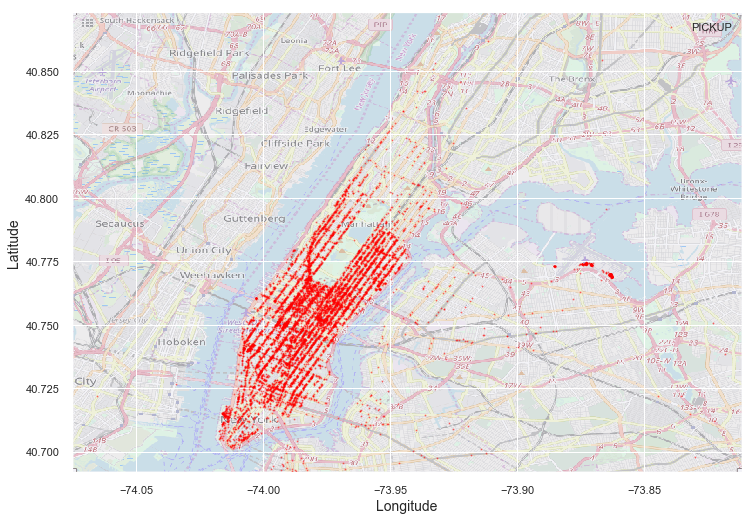

In [384]:
taxi_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4,
          label='PICKUP', figsize=(12,10), s = 1, color='red')

plt.imshow(map_, extent=[-74.0753, -73.8116, 40.6921, 40.8730], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
plt.show()

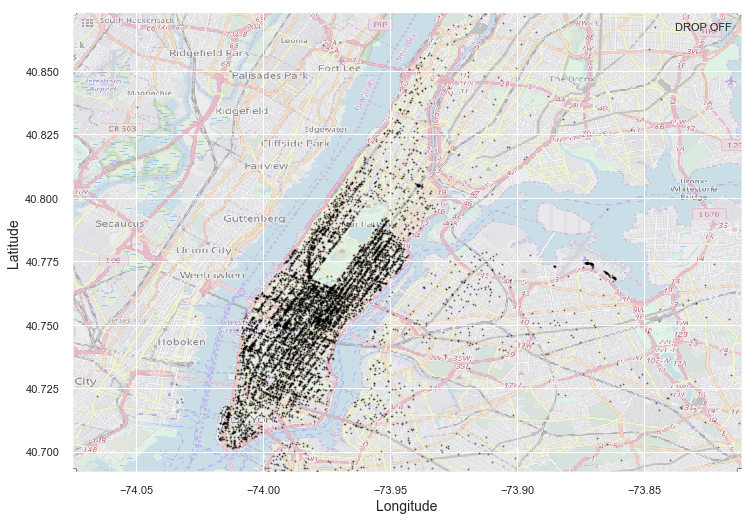

In [385]:
taxi_coordinates.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4,
          label='DROP OFF', figsize=(12,10), s = 1, color='black')

plt.imshow(map_, extent=[-74.0753, -73.8116, 40.6921, 40.8730], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
plt.show()

In [386]:
taxi_coordinates.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_neighbourhood
658656,id2552518,2,2016-03-20 21:05:42,2016-03-20 21:29:24,1,-73.870888,40.773766,-73.980980,40.750957,N,1422,3
1447231,id3693918,2,2016-01-22 22:10:27,2016-01-22 22:42:15,3,-73.985840,40.746597,-73.928055,40.702003,N,1908,2
1398855,id0436568,1,2016-06-22 15:09:10,2016-06-22 15:18:40,1,-73.998955,40.754913,-73.981438,40.768478,N,570,2
911760,id1340416,2,2016-06-04 01:18:16,2016-06-04 01:39:58,2,-73.951881,40.777630,-73.893723,40.746433,N,1302,0
1168143,id3936244,1,2016-02-08 18:43:53,2016-02-08 19:13:21,2,-73.981636,40.758652,-73.958687,40.718952,N,1768,4


We can use this information to cluster NYC based on the taxi pickup & dropoff locations and then use this information for further clustering

### K-means clustering for neighbourhoods

Find the optimal number of clusters

In [387]:
X_pickup = taxi_coordinates[['pickup_longitude', 'pickup_latitude']]
X_dropoff = taxi_coordinates[['dropoff_longitude', 'dropoff_latitude']]

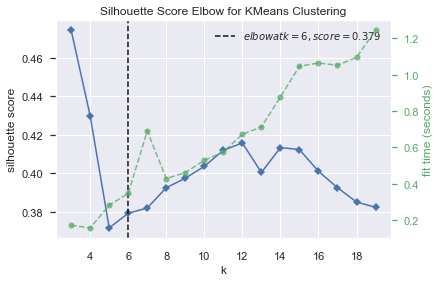

In [373]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')
visualizer.fit(X_pickup)
visualizer.poof()

In [374]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(3,20), metric='distortion')
# visualizer.fit(X)
# visualizer.poof()

In [375]:
# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(3,20), metric='calinski_harabasz')
# visualizer.fit(X)
# visualizer.poof()

Apply the optimal number of clusters to the model for pickups

In [388]:
kmeans = KMeans(n_clusters=6, random_state=8)
neighbourhood_clusters = kmeans.fit(X_pickup)

In [389]:
unique, counts = np.unique(neighbourhood_clusters.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([1410, 1604, 2569,  278, 2796,  676]))

In [390]:
taxi_coordinates['pickup_neighbourhood'] = neighbourhood_clusters.labels_

In [391]:
taxi_coordinates.pickup_neighbourhood.value_counts()

4    2796
2    2569
1    1604
0    1410
5     676
3     278
Name: pickup_neighbourhood, dtype: int64

Plot results:

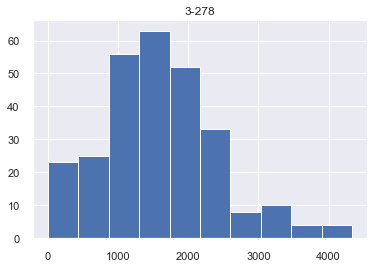

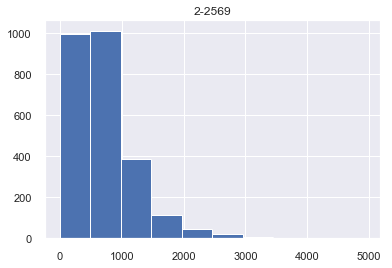

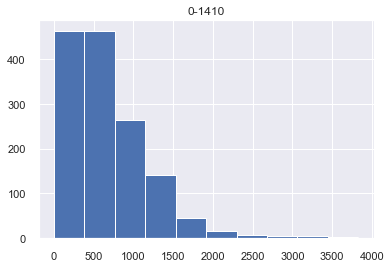

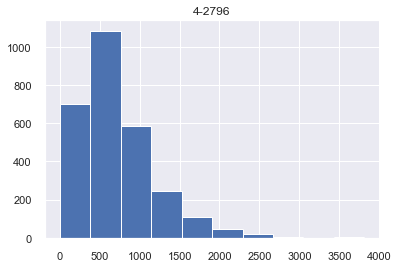

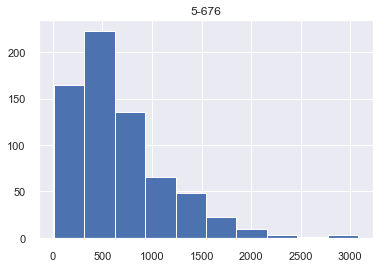

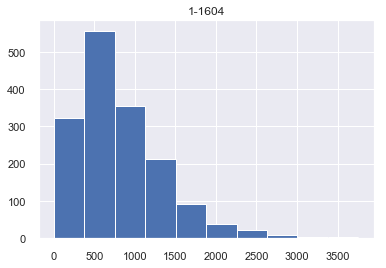

In [392]:
for cluster in taxi_coordinates.pickup_neighbourhood.unique():
    taxi_coordinates[taxi_coordinates['pickup_neighbourhood']==cluster].trip_duration.hist()
    plt.title(str(cluster) + "-" + str(taxi_coordinates[taxi_coordinates['pickup_neighbourhood']==cluster].shape[0]))
    plt.show()

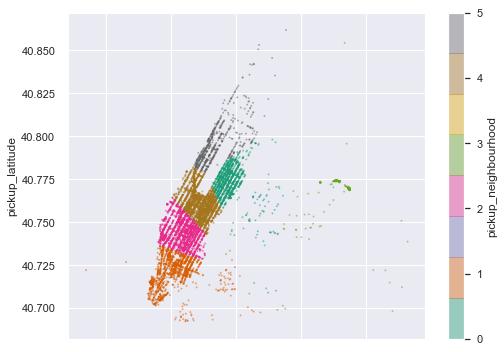

In [393]:
taxi_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(8,6), s = 1, c ='pickup_neighbourhood', cmap=plt.get_cmap('Dark2'))

Do the clustering for dropoff

In [394]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')
visualizer.fit(X_dropoff)
visualizer.poof()

KeyboardInterrupt: 

In [395]:
kmeans = KMeans(n_clusters=8, random_state=8)
neighbourhood_clusters = kmeans.fit(X_dropoff)

In [396]:
taxi_coordinates['dropoff_neighbourhood'] = neighbourhood_clusters.labels_

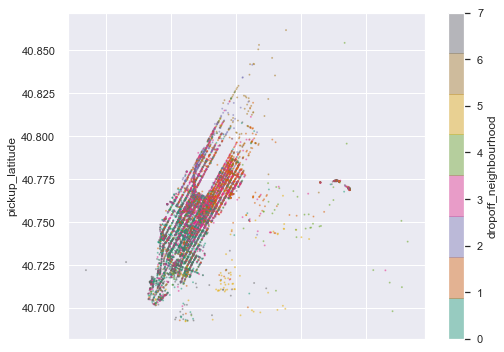

In [397]:
taxi_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(8,6), s = 1, c ='dropoff_neighbourhood', cmap=plt.get_cmap('Dark2'))

Check trip duration distribution (convert seconds to hours for plotting purposes)

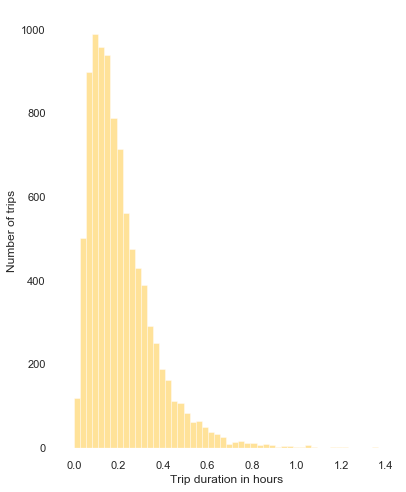

In [398]:
sns.set(color_codes=True)

duration = taxi_coordinates.trip_duration/60/60

plt.figure(figsize=(6,8))
ax = sns.distplot(duration, bins=50, kde=False, color='#ffb700')
ax.patch.set_facecolor('white')
plt.xlabel("Trip duration in hours", fontsize=12)
plt.ylabel("Number of trips", fontsize=12)
plt.show()

In [399]:
taxi_coordinates.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood
658656,id2552518,2,2016-03-20 21:05:42,2016-03-20 21:29:24,1,-73.870888,40.773766,-73.980980,40.750957,N,1422,3,3
1447231,id3693918,2,2016-01-22 22:10:27,2016-01-22 22:42:15,3,-73.985840,40.746597,-73.928055,40.702003,N,1908,2,5
1398855,id0436568,1,2016-06-22 15:09:10,2016-06-22 15:18:40,1,-73.998955,40.754913,-73.981438,40.768478,N,570,2,3
911760,id1340416,2,2016-06-04 01:18:16,2016-06-04 01:39:58,2,-73.951881,40.777630,-73.893723,40.746433,N,1302,0,4
1168143,id3936244,1,2016-02-08 18:43:53,2016-02-08 19:13:21,2,-73.981636,40.758652,-73.958687,40.718952,N,1768,4,5


In [400]:
taxi_coordinates_neigh = taxi_coordinates.copy()

In [402]:
taxi_coordinates.drop(['pickup_neighbourhood', 'dropoff_neighbourhood'], inplace=True, axis=1)

### Further cleaning & data engineering for 2nd clustering

Drop id, store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [403]:
taxi_coordinates_neigh.dtypes

id                        object
vendor_id                  int64
pickup_datetime           object
dropoff_datetime          object
passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
dropoff_longitude        float64
dropoff_latitude         float64
store_and_fwd_flag        object
trip_duration              int64
pickup_neighbourhood       int32
dropoff_neighbourhood      int32
dtype: object

In [404]:
taxi_coordinates_neigh.pickup_datetime = pd.to_datetime(taxi_coordinates_neigh.pickup_datetime)
taxi_coordinates_neigh.dropoff_datetime = pd.to_datetime(taxi_coordinates_neigh.dropoff_datetime)

In [405]:
taxi_coordinates2 = taxi_coordinates_neigh.copy()
taxi_coordinates2.drop(['id', 'store_and_fwd_flag', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude', 'trip_duration'], inplace=True, axis=1)

In [406]:
taxi_coordinates2.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_neighbourhood,dropoff_neighbourhood
658656,2016-03-20 21:05:42,2016-03-20 21:29:24,1,3,3
1447231,2016-01-22 22:10:27,2016-01-22 22:42:15,3,2,5
1398855,2016-06-22 15:09:10,2016-06-22 15:18:40,1,2,3
911760,2016-06-04 01:18:16,2016-06-04 01:39:58,2,0,4
1168143,2016-02-08 18:43:53,2016-02-08 19:13:21,2,4,5


Feature engineering on datetime: convert pick up and drop off dates to datetime

In [407]:
import datetime

def get_data(dt):
    return [dt.month_name(), dt.day_name(), dt.hour]

taxi_coordinates2['pickup'] = pd.to_datetime(taxi_coordinates2.pickup_datetime).map(get_data)
taxi_coordinates2['dropoff'] = pd.to_datetime(taxi_coordinates2.pickup_datetime).map(get_data)

In [408]:
taxi_coordinates2.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup,dropoff
658656,2016-03-20 21:05:42,2016-03-20 21:29:24,1,3,3,"[March, Sunday, 21]","[March, Sunday, 21]"
1447231,2016-01-22 22:10:27,2016-01-22 22:42:15,3,2,5,"[January, Friday, 22]","[January, Friday, 22]"
1398855,2016-06-22 15:09:10,2016-06-22 15:18:40,1,2,3,"[June, Wednesday, 15]","[June, Wednesday, 15]"
911760,2016-06-04 01:18:16,2016-06-04 01:39:58,2,0,4,"[June, Saturday, 1]","[June, Saturday, 1]"
1168143,2016-02-08 18:43:53,2016-02-08 19:13:21,2,4,5,"[February, Monday, 18]","[February, Monday, 18]"


In [409]:
taxi_drop = taxi_coordinates2.copy()
taxi_drop.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [410]:
column_names = ['pickup_month', 'pickup_day', 'pickup_hour']

for i in range(len(column_names)):
    taxi_drop[column_names[i]] = [x[i] for x in taxi_drop['pickup']]

In [411]:
column_names = ['dropoff_month', 'dropoff_day', 'dropoff_hour']

for i in range(len(column_names)):
    taxi_drop[column_names[i]] = [x[i] for x in taxi_drop['dropoff']]

In [412]:
taxi_drop.drop(['pickup', 'dropoff'], inplace=True, axis=1)
taxi_drop.head()

,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup_month,pickup_day,pickup_hour,dropoff_month,dropoff_day,dropoff_hour
658656,1,3,3,March,Sunday,21,March,Sunday,21
1447231,3,2,5,January,Friday,22,January,Friday,22
1398855,1,2,3,June,Wednesday,15,June,Wednesday,15
911760,2,0,4,June,Saturday,1,June,Saturday,1
1168143,2,4,5,February,Monday,18,February,Monday,18


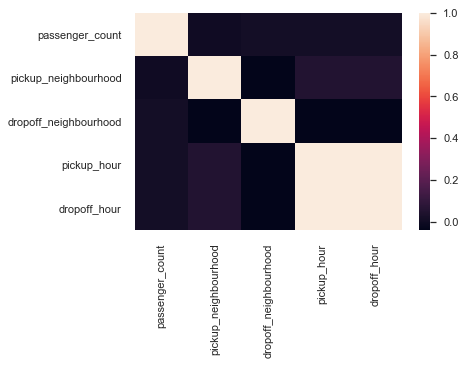

In [413]:
sns.heatmap(taxi_drop.corr())

While pickup & drop off are highly correlated, as we're trying to cluster based on trip duration, we will keep this information. We will drop pick up & drop off datetime as we now have the month, hour & day columns

Plot trips by day

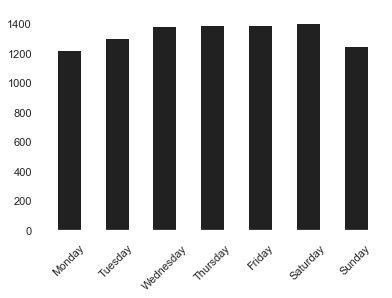

In [414]:
days_grouped = taxi_drop.groupby(['pickup_day']).count().passenger_count.reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = days_grouped['pickup_day'].map(mapping)    
days_grouped = days_grouped.iloc[key.argsort()]

ax = days_grouped.plot(kind='bar', x='pickup_day', legend = False, color=["#212121","#ffb700"])
ax.set_xticklabels(labels=weekdays, rotation=45)
ax.patch.set_facecolor('white')
plt.xlabel("")
plt.show()

Plot trips by hour

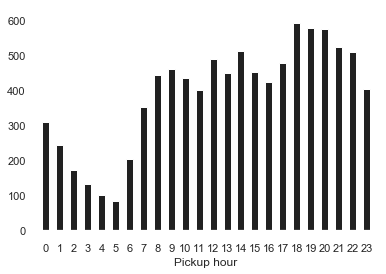

In [415]:
h_grouped = taxi_drop.groupby(['pickup_hour']).count().passenger_count.reset_index()
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

ax = h_grouped.plot(kind='bar', x='pickup_hour', legend = False, color=["#212121","#ffb700"])
ax.xaxis.set_tick_params(rotation=0)
ax.patch.set_facecolor('white')
plt.xlabel("Pickup hour")
plt.show()

Plot pickup hours for working days vs weekend

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


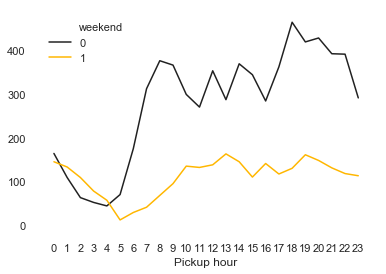

In [416]:
week_vs_wkd = taxi_drop[['pickup_day', 'pickup_hour', 'passenger_count']]
week_vs_wkd['weekend'] = np.where(week_vs_wkd.pickup_day == 'Saturday', 1, 
                                  np.where(week_vs_wkd.pickup_day == 'Sunday', 1, 0))
h_grouped = week_vs_wkd.groupby(['weekend', 'pickup_hour']).count().passenger_count.reset_index()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

colors = ["#212121","#ffb700"]
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x="pickup_hour", y="passenger_count", hue="weekend", data=h_grouped)
plt.xlabel("Pickup hour")
plt.ylabel("")
ax.patch.set_facecolor('white')
ax.set_xticks(range(0,24))
plt.show()

See if need to add weekend column

In [417]:
# taxi_drop['weekend'] = np.where(taxi_drop.pickup_day == 'Saturday', 1, 
#                                   np.where(taxi_drop.pickup_day == 'Sunday', 1, 0))

Create labels of the day to put hours in 4 bins

In [418]:
day_labels = ['night', 'morning', 'afternoon', 'evening']
cutoffs = [-1, 5, 11, 17, 23]
taxi_drop['pickup_timeofday'] = pd.cut(taxi_drop['pickup_hour'], cutoffs, labels=day_labels)
taxi_drop['dropoff_timeofday'] = pd.cut(taxi_drop['dropoff_hour'], cutoffs, labels=day_labels)

In [419]:
taxi_drop2 = taxi_drop.copy()
taxi_drop2.drop(['pickup_hour', 'dropoff_hour'], inplace=True, axis=1)

In [420]:
taxi_drop2.head()

,passenger_count,pickup_neighbourhood,dropoff_neighbourhood,pickup_month,pickup_day,dropoff_month,dropoff_day,pickup_timeofday,dropoff_timeofday
658656,1,3,3,March,Sunday,March,Sunday,evening,evening
1447231,3,2,5,January,Friday,January,Friday,evening,evening
1398855,1,2,3,June,Wednesday,June,Wednesday,afternoon,afternoon
911760,2,0,4,June,Saturday,June,Saturday,night,night
1168143,2,4,5,February,Monday,February,Monday,evening,evening


Do one hot encoding on day, time of day & neigbourhood fields to transform the categorical variable

In [421]:
taxi_days = pd.get_dummies(data=taxi_drop2, columns=['pickup_neighbourhood', 'dropoff_neighbourhood',
                                                     'pickup_month', 'pickup_day', 'dropoff_month', 
                                                     'dropoff_day', 'pickup_timeofday','dropoff_timeofday'])

In [422]:
taxi_days.head()

,passenger_count,pickup_neighbourhood_0,pickup_neighbourhood_1,pickup_neighbourhood_2,pickup_neighbourhood_3,pickup_neighbourhood_4,pickup_neighbourhood_5,dropoff_neighbourhood_0,dropoff_neighbourhood_1,dropoff_neighbourhood_2,...,dropoff_day_Tuesday,dropoff_day_Wednesday,pickup_timeofday_night,pickup_timeofday_morning,pickup_timeofday_afternoon,pickup_timeofday_evening,dropoff_timeofday_night,dropoff_timeofday_morning,dropoff_timeofday_afternoon,dropoff_timeofday_evening
658656,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1447231,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1398855,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
911760,2,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1168143,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [423]:
taxi_days.shape

(9333, 49)

In [433]:
principalDf = taxi_days.copy()

### K-Means Clustering

Do further clustering for the new dataset to search for clusters based on pickup & dropoff time/day

Use elbow curve for cluster number

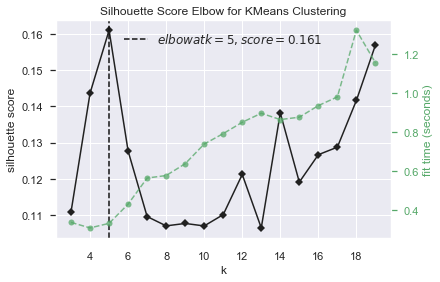

In [243]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')
visualizer.fit(principalDf)
visualizer.poof()

In [434]:
kmeans = KMeans(n_clusters=5)
taxi_clusters = kmeans.fit(principalDf)
labels =taxi_clusters.predict(principalDf)

In [435]:
unique, counts = np.unique(taxi_clusters.labels_, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4], dtype=int32), array([ 931, 2521, 2049, 2868,  964]))

In [436]:
principalDf['final_clusters'] = taxi_clusters.labels_

In [437]:
principalDf.final_clusters.value_counts()

3    2868
1    2521
2    2049
4     964
0     931
Name: final_clusters, dtype: int64

In [442]:
from sklearn.metrics import silhouette_score 

X_cols = [col for col in principalDf.columns if col != 'final_clusters']
X = principalDf[X_cols]

score = silhouette_score(X, labels, metric='euclidean')
score

0.16143644469149215

### DBscan

In [445]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

In [452]:
principalDf.drop('final_clusters', inplace=True, axis = 1)

In [453]:
# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(principalDf) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [454]:
#Reducing the dimensionality of the data to make it visualizable

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
print(X_principal.head()) 

         P1        P2
0  0.180575 -0.085013
1  0.244742 -0.114950
2 -0.265636 -0.014230
3 -0.030710 -0.074266
4  0.288140 -0.027519


In [469]:
# Building the clustering model
# Numpy array of all the cluster labels assigned to each data point 

db_default = DBSCAN(eps = 0.027, min_samples = 5).fit(X_principal) 
labels = db_default.labels_ 

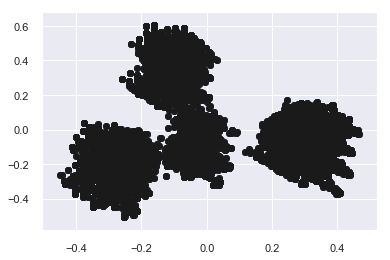

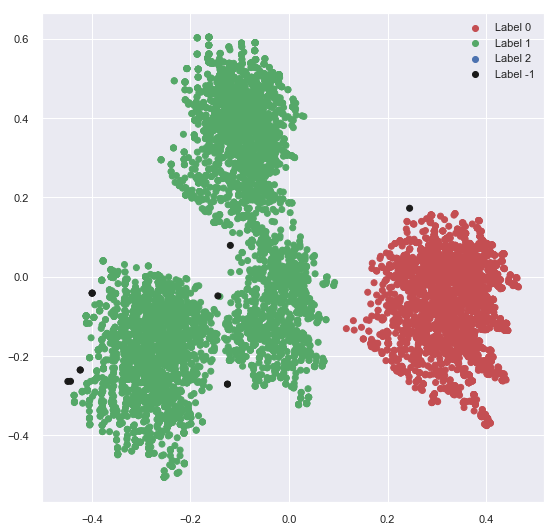

In [470]:
# Visualizing the clustering

# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels] 
  
# For the construction of the legend of the plot 
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r'); 
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g'); 
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b'); 
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k'); 
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
  
# Building the legend 
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1')) 
  
plt.show() 

### Hierarchical clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
hier_clust = AgglomerativeClustering(linkage='ward')
taxi_hier = hier_clust.fit(principalDf)

In [ ]:
from scipy.cluster import hierarchy

def plot_dendrogram(model, **kwargs): 
    children = model.children_ 
    distance = np.arange(children.shape[0]) 
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float) 
    hierarchy.dendrogram(linkage_matrix, **kwargs) 

plot_dendrogram(taxi_hier, labels=taxi_hier.labels_)